Data wrangling

# Problem statement
The goal for this project is to predict sales next calendar year for different Walmart stores based on two past year sales. With knowing the sales in the future, the management team will be able to provide guidance for supply chains to properly manage the inventory and allocate their resources, react to a market change, this help prevent unnecessary money loss. This can also be used to set sales target for sales department
success creterion: prediction accuracy rate is greater than 0.9
scope of solutions: ??
Sales can be reponsive to time factor(date, year, day, week, month, holiday) and space factor(store, dept, store type/size)

ways for predictions: 
Is it better to have one model for each location or one mode for all locations?
Is it better to have one model for each forecast time or one for all forecast times?

# 1. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from collections import Counter
from datetime import datetime

In [2]:
stores = pd.read_csv(r'C:/New folder/capstone 2/data/stores.csv')

In [3]:
features=pd.read_csv(r'C:/New folder/capstone 2/data/features.csv')

In [4]:
Weekly_sales=pd.read_csv(r'C:/New folder/capstone 2/data/train.csv')

In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [7]:
Weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


# 2. Exploring data

## 2.1 find duplicates

In [8]:
#find duplicates in stores df
#find number of stores, make sure there is no duplicates
stores_count=stores['Store'].value_counts(sort=True)
print(stores_count.head())
#stores_count_dict=stores_count.to_dict
#print(k for k, v in stores_count_dict.items() if v>1)

1     1
24    1
26    1
27    1
28    1
Name: Store, dtype: int64


In [9]:
#find duplicates in weekly_sales df
#Weekly_sales[Weekly_sales.duplicated(subset=['Store','Dept','Date'], keep=False)]

Weekly_sales.duplicated(keep=False).sum()

0

In [10]:
#find duplicates in features df based on selected columns
#features[features.duplicated(subset=['Store','Date'], keep=False)]

features.duplicated(keep=False).sum()

0

## 2.2 find dimensions for all time series 

In [11]:
# stores df does not contain any time series
#feature and weekly_sales df contains time series
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
#feature df contains store and date information, find the number of stores in features
features.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [13]:
Weekly_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [14]:
#Weekly_sales df contains store/dept and date information, find the number of stores and dept in df
Weekly_sales.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [15]:
#count # of Dept in each store 
#https://stackoverflow.com/questions/38309729/count-unique-values-per-groups-with-pandas
Weekly_sales.groupby('Store').Dept.nunique()

Store
1     77
2     78
3     72
4     78
5     72
6     77
7     76
8     76
9     73
10    77
11    78
12    75
13    79
14    77
15    79
16    76
17    76
18    78
19    79
20    78
21    77
22    76
23    77
24    77
25    77
26    76
27    78
28    77
29    77
30    64
31    76
32    77
33    63
34    78
35    74
36    63
37    62
38    63
39    75
40    77
41    77
42    62
43    61
44    62
45    74
Name: Dept, dtype: int64

In [16]:
#total # of time series are 
Weekly_sales.groupby('Store').Dept.nunique().sum()

3331

## 2.3 finding missing values

In [17]:
Weekly_sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [18]:
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [19]:
features_missing = pd.concat([features.isnull().sum(), 100 * features.isnull().mean()],axis=1)
features_missing.columns=['count','%']
features_missing

,count,%
Store,0,0.000000
Date,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,4158,50.769231
MarkDown2,5269,64.334554
MarkDown3,4577,55.885226
MarkDown4,4726,57.704518
MarkDown5,4140,50.549451
CPI,585,7.142857


since this is time series dataset, the missing value will be treated differently in EDA

## 2.4 Categorical features

### 2.4.1 store type

#### 2.4.1.1 store type distribution

In [20]:
# work on stores df
#count # of stores for each type
store_type=stores.groupby('Type').count()
store_type.drop(['Store'], axis=1,inplace=True)
store_type.rename(columns={'Size':'counts'},inplace=True)
store_type

,counts
Type,
A,22
B,17
C,6


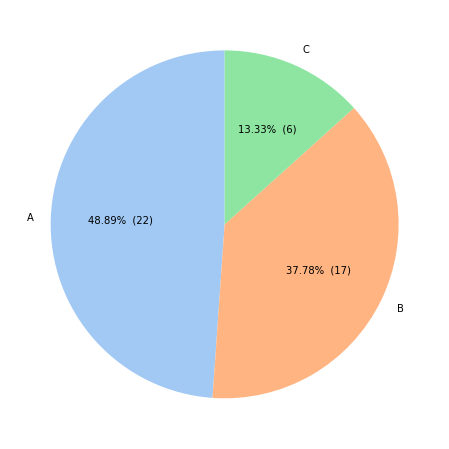

In [21]:
#plot pie chart for store type distribution with defined size
plt.figure(figsize=(10,8))

#define colors, refer to https://www.statology.org/seaborn-pie-chart/
colors = sns.color_palette('pastel')[0:3]  

store_type.reset_index(inplace=True)
label = store_type.Type
data = store_type.counts

#define function to plot both ratio and number for each store type
#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct#:~:text=autopct%20enables%20you%20to%20display,set%20to%20the%20string%20'%25.
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(data,labels=label, colors=colors,startangle = 90, autopct=make_autopct(data))
#plt.title="store type distribution"
plt.show()

#### 2.4.1.2 mean store size by store type

In [22]:
stores.groupby('Type',as_index=False)['Size'].mean()

,Type,Size
0,A,177247.727273
1,B,101190.705882
2,C,40541.666667


<AxesSubplot:xlabel='Type', ylabel='Size'>

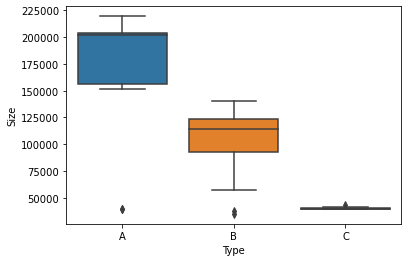

In [23]:
#plot boxplot of store size based on different store type
#sns.violinplot(x="Type", y="Size", data=stores); 
#https://hippocampus-garden.com/pandas_boxplot/

#stores.groupby('Type').boxplot(column='Size')

sns.boxplot(x="Type", y="Size", data=stores)


#### 2.4.1.3 boxplot of weekly sales by store type

In [24]:
Weekly_sales_type=pd.merge(Weekly_sales,stores, how='left', on='Store')
Weekly_sales_type.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


Text(0.5, 0, 'Store')

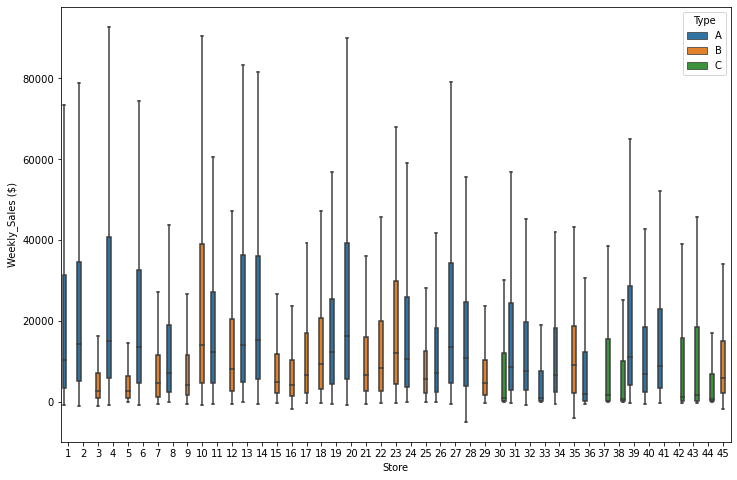

In [25]:
#plot weekly sales distribution for each store, comparing between different store types
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Store', y='Weekly_Sales', hue='Type', showfliers=False, data=Weekly_sales_type)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store')

Text(0.5, 0, 'Store type')

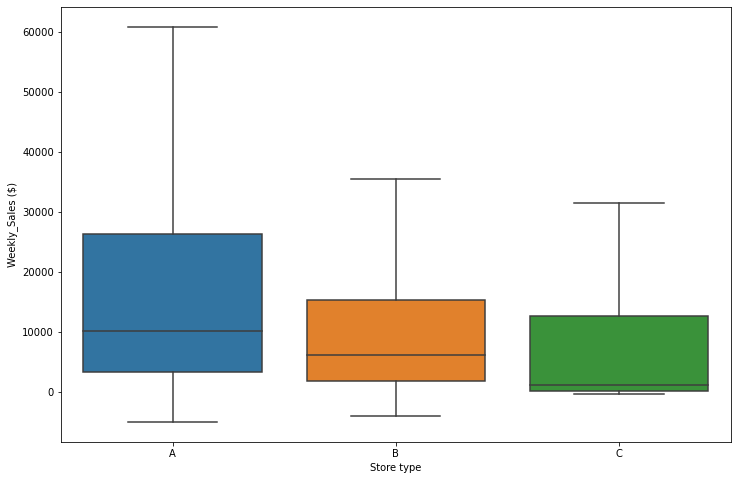

In [26]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Type', y='Weekly_Sales', showfliers=False, data=Weekly_sales_type)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store type')

Type A has highest average weekly sales comparing to type B,C

### 2.4.2 holiday effect

Text(0.5, 0, 'IsHoliday')

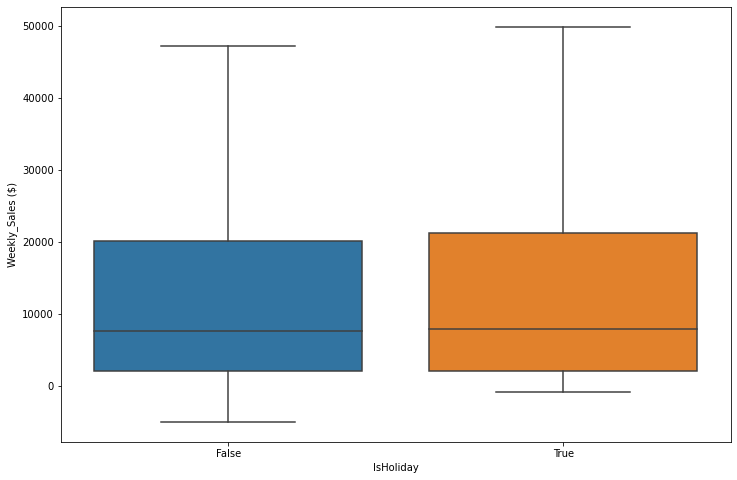

In [27]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', showfliers=False, data=Weekly_sales_type)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('IsHoliday')

Text(0.5, 0, 'Store')

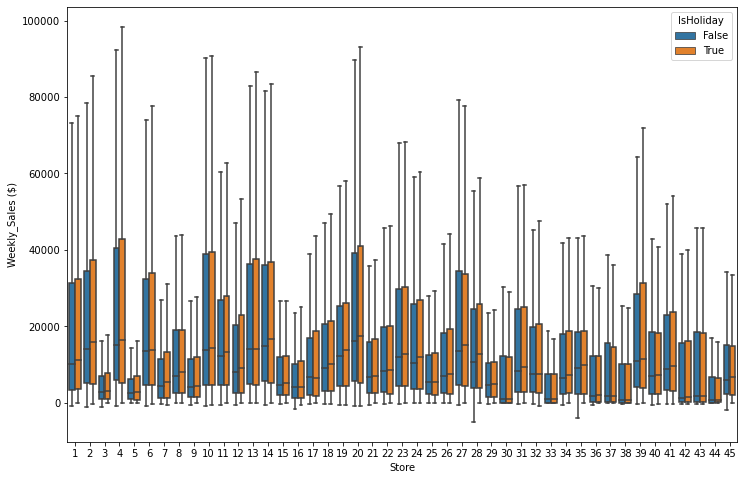

In [28]:
#plot weekly sales distribution for each store, comparing holiday with non-holidays
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Store', y='Weekly_Sales', hue='IsHoliday', showfliers=False, data=Weekly_sales)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store')
#plt.yscale('log')
#plt.ylim(0,30000)

## 2.5 numerical variables

### 2.5.1 numerical variables in features df

In [29]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [30]:
features.Date=pd.to_datetime(features.Date)

In [31]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,8190.0,23.000000,12.987966,1.000,12.000000,23.000000,34.000000,45.000000
Temperature,8190.0,59.356198,18.678607,-7.290,45.902500,60.710000,73.880000,101.950000
Fuel_Price,8190.0,3.405992,0.431337,2.472,3.041000,3.513000,3.743000,4.468000
MarkDown1,4032.0,7032.371786,9262.747448,-2781.450,1577.532500,4743.580000,8923.310000,103184.980000
MarkDown2,2921.0,3384.176594,8793.583016,-265.760,68.880000,364.570000,2153.350000,104519.540000
MarkDown3,3613.0,1760.100180,11276.462208,-179.260,6.600000,36.260000,163.150000,149483.310000
MarkDown4,3464.0,3292.935886,6792.329861,0.220,304.687500,1176.425000,3310.007500,67474.850000
MarkDown5,4050.0,4132.216422,13086.690278,-185.170,1440.827500,2727.135000,4832.555000,771448.100000
CPI,7605.0,172.460809,39.738346,126.064,132.364839,182.764003,213.932412,228.976456
Unemployment,7605.0,7.826821,1.877259,3.684,6.634000,7.806000,8.567000,14.313000


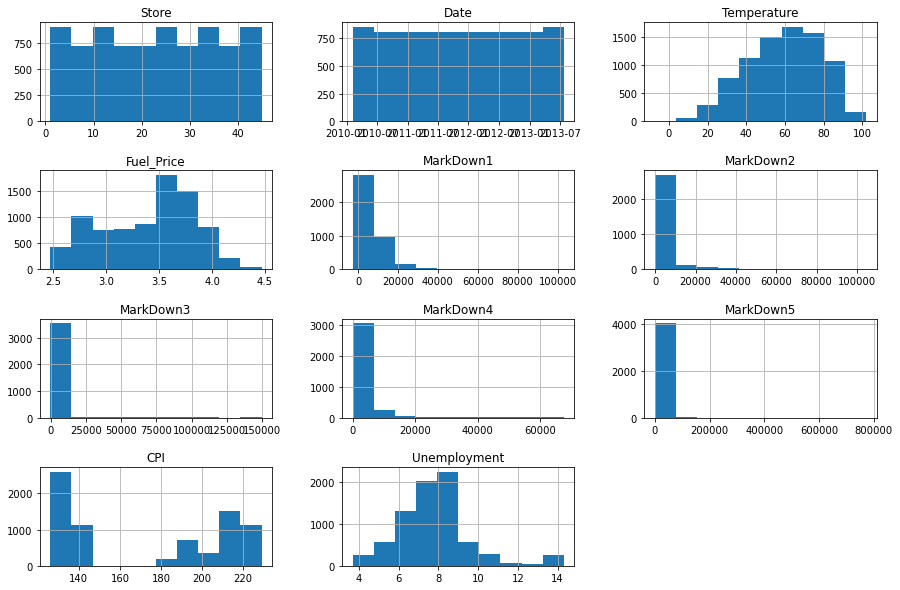

In [32]:
features.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [33]:
#markdown values less than 0 and more than 10000 makes nonsense, find #of makedown values in the "outlier" range
features_out_range=features[(features['MarkDown1']>10000)|(features['MarkDown2']>100)|(features['MarkDown3']>10000)|(features['MarkDown4']>10000)|(features['MarkDown5']>10000)]

In [34]:
#markdown values less than 0
features_neg=features[(features['MarkDown1']<0)|(features['MarkDown2']<0)|(features['MarkDown3']<0)|(features['MarkDown5']<0)]

In [35]:
#ratio of obs which contains markdown values in the outlier range
(features_out_range.shape[0]+features_neg.shape[0])/features.shape[0]

0.3070818070818071

### 2.5.2 numerical features in weekly_sales_type df

In [36]:
Weekly_sales_type.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.00,11.00,22.00,33.0000,45.00
Dept,421570.0,44.260317,30.492054,1.00,18.00,37.00,74.0000,99.00
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
Size,421570.0,136727.915739,60980.583328,34875.00,93638.00,140167.00,202505.0000,219622.00


In [37]:
Weekly_sales_out_range=Weekly_sales_type[Weekly_sales_type.Weekly_Sales<0]

In [38]:
(Weekly_sales_out_range.shape[0])/Weekly_sales_type.shape[0]

0.0030481296107408022

(array([ 73341.,      0.,   9443.,   9762.,      0.,      0.,  19319.,
          9528.,  19755.,  58267.,   9804.,   9582.,  20098.,  30136.,
             0.,      0.,   9878.,  20128., 112055.,  10474.]),
 array([ 34875.  ,  44112.35,  53349.7 ,  62587.05,  71824.4 ,  81061.75,
         90299.1 ,  99536.45, 108773.8 , 118011.15, 127248.5 , 136485.85,
        145723.2 , 154960.55, 164197.9 , 173435.25, 182672.6 , 191909.95,
        201147.3 , 210384.65, 219622.  ]),
 <BarContainer object of 20 artists>)

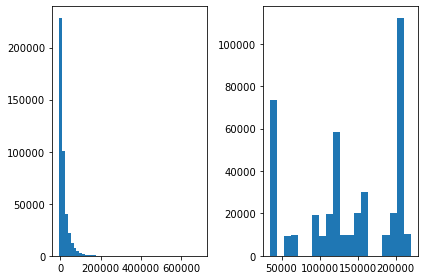

In [39]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(Weekly_sales_type.Weekly_Sales, bins=50)
axs[1].hist(Weekly_sales_type.Size, bins=20)

 ## 2.6 weekly_sales trend overview

In [40]:
Weekly_sales_type.Date=pd.to_datetime(Weekly_sales_type.Date)

In [41]:
df=pd.merge(Weekly_sales_type,features, how='left', on=['Store', 'Date'])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [42]:
#check if two holiday cols are same
df['IsHoliday_x'].equals(df['IsHoliday_y'])

True

In [43]:
df.drop(columns='IsHoliday_y',inplace=True)
df.rename(columns={'IsHoliday_x':'Holiday'},inplace=True)

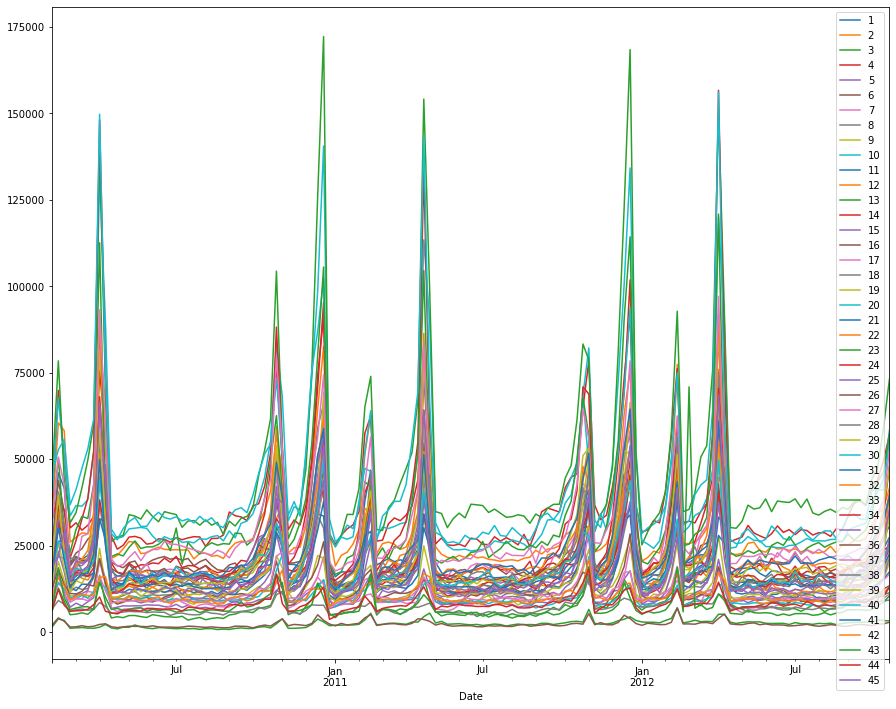

In [44]:
df_dept1=df[(df['Dept']==1)]

fig, ax = plt.subplots(figsize=(15, 12))

df_dept1_group= df_dept1.groupby('Store')

for key in df_dept1_group.groups.keys():
    df_dept1_group.get_group(key).plot('Date', 'Weekly_Sales', ax=ax, label=key)

In [45]:
df_dept1_group.head()

,Store,Dept,Date,Weekly_Sales,Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411933,45,1,2010-02-05,18628.11,False,B,118221,27.31,2.784,NaN,NaN,NaN,NaN,NaN,181.871190,8.992
411934,45,1,2010-02-12,22416.94,True,B,118221,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992
411935,45,1,2010-02-19,28756.53,False,B,118221,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992
411936,45,1,2010-02-26,14656.08,False,B,118221,34.89,2.754,NaN,NaN,NaN,NaN,NaN,182.077469,8.992


In [46]:
df_dept1_group.groups

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], 2: [10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 

In [47]:
df_dept1_group.groups[2]

Int64Index([10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252,
            10253,
            ...
            10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385,
            10386],
           dtype='int64', length=143)

In [48]:
df_dept1_group.get_group(1)

,Store,Dept,Date,Weekly_Sales,Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False,A,151315,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.981658,6.908
139,1,1,2012-10-05,21904.47,False,A,151315,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,223.181477,6.573
140,1,1,2012-10-12,22764.01,False,A,151315,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573
141,1,1,2012-10-19,24185.27,False,A,151315,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,223.425723,6.573


In [50]:
df.set_index("Date",inplace=True)
df.head()

,Store,Dept,Weekly_Sales,Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [51]:
#starting point for weekly sales
min(df.index)

Timestamp('2010-02-05 00:00:00')

In [52]:
#end point for weekly sales
max(df.index)

Timestamp('2012-10-26 00:00:00')

In [54]:
Num_of_weeks=(max(df.index)-min(df.index))//7
Num_of_weeks

Timedelta('142 days 00:00:00')

In [57]:
len(df_dept1_group.groups)

45

In [59]:
#find # of weekly_sales records for each store/dept
df_group=df.groupby(['Store','Dept']).size()
df_group=df_group.to_frame()
df_group.reset_index(inplace=True)
df_group.rename(columns={0:'counts'},inplace=True)
df_group.tail()

,Store,Dept,counts
3326,45,94,134
3327,45,95,143
3328,45,96,2
3329,45,97,143
3330,45,98,135


In [61]:
#find # of weekly_sales records less than 143-time gap, about 671 out of 3331 records have time gaps (~20%)
df_count = (df_group.counts <143).sum()
df_count

671

In [62]:
df.to_csv(r'C:/New folder/capstone 2/data/df_clean.csv', index=False)

Summary:
1) there are three datasets: features contains local information(CPI, unemployment, T and markdown values) change in time series, type contains store size and type. weekly sales contains weekly sales for each store and dept.
2) no duplicates found in the datasets
3) no missing values found in dataset weekly sales and type;
   missing values found in dataset "features"
categorical features   
4) total # of stores are 45, each of the store have about 60-80 depts, store #30,33, 36-38, 42-44 have less depts(~60) than the rest. majority stores have 72-80 depts. total number of time series are 3331. 
*total depts are 81, least popular dept are 65, 43 and 39 
5) range of datetime is from Feb.05,2010 to Oct. 26,2012
6) In terms of categorical feature analysis, half of the stores are type A and have largest size in average, type C has smallest size in average and least number of stores; Type A tends to have highest average weekly sales value
7) Comparing holidays and nonholidays for weekly sales, the median values overall are similar, max /min sales values are higher on holidays than that on non-holidays; when looking at each store, the holiday weekly sales is alway lightly higher than non-holidays
8) for majority of the stores, each dept seems to follow its own seasonality trend on weekly sales
numerical features
9) for numerical features, missing values in markdown of feature dataset are about 50% above, missing values in CPI and unemployment is about 7%, cannot replaced with median value
10) abnormal markdown(>100% or <0%) values are observed, about 30%, not sure what value to replace it 
11) abnormal(negative) weekly sales are observed (about 1285 out of 421K, 0.3%)
12) about 20% times series data sets have time gaps
